## Import packages

In [1]:
import numpy as np
import numpy.matlib as npm
import matplotlib.pyplot as plt
import scipy.linalg
import scipy.stats
import time
import os

## Dataset

### Load dataset (Mushuroom)

In [2]:
data = np.loadtxt('mushroom_dataset/agaricus-lepiota.data', delimiter=',', dtype=str) # load
attr = [{val: int(cnt) for cnt, val in enumerate(list(set(data[:,i])))} for i in range(len(data[0,:]))] # dict mapping
data = np.array([np.array([attr[i][e] for e in data[:,i]]) for i in range(len(data[0,:]))]).T # swap str to int

### Data preparation (Check columns)

In [3]:
cols = [i for i,e in enumerate(attr) if len(e)==1]
for col in cols:
    data = np.delete(data, col, axis=1)

### Standardize or Normalize dataset

In [4]:
data_attr = data[:,:-1]

### Standardization: (d - mean ) / std        [For each column]
data[:,:-1] = (data_attr - np.mean(data_attr, axis=0)) / np.std(data_attr, axis=0)

### Normalization  : (d - min) / (max - min)  [For each column]
# data[:,:-1] = ( data_attr - np.min(data_attr, axis=0) ) / ( np.max(data_attr, axis=0) - np.min(data_attr, axis=0) )

## Classifiers

### LMQ - Linear dos Mínimos Quadrados

In [5]:
def LMQ_classifier(data, n_runs=100, p_train=0.8, silent=False, plot=True):
    # Variables
    name = 'LMQ'
    desc = 'Linear dos Mínimos Quadrados (LMQ)'
    if silent==False:
        print('> {}'.format(desc))

    # General variables
    N_samples = len(data)
    N_attribs = len(data[0])-1
    N_train   = round(p_train*N_samples)
    N_test    = N_samples-N_train
    K         = int(np.max(data[:,-1]))
    rates     = np.array([]) # Accuracys
    t_train   = np.array([]) # Train Times
    t_test    = np.array([]) # Test Times
    confusion = np.zeros((K,K))
    stats     = {}
    if silent==False:
        print('> The problem has {} classes'.format(K))
    
    # Loop of independent runs
    for loop in range(1, n_runs+1):
        ### Train phase

        # Begin train time
        t_train = np.append(t_train, time.time())

        # Shuffle rows of the data matrix
        np.random.shuffle(data)

        # Split into training and tests subsets
        data_train = data[:N_train]
        data_test  = data[N_train:]

        # Partition of training data into attributes and label
        X_train = data_train[:,:-1]
        Y_train = data_train[:,-1]

        # Routine to convert numerical labels into binary (1-out-of-K) labels
        labels_train = np.zeros((N_train, K))
        labels = np.eye(K)
        for k in range(1,K+1):
            yK = np.where(Y_train[:] == k)
            labels_train[yK,:] = npm.repmat(labels[k-1,:], len(yK), 1)
        
        # Compute the weight matrix (N_attribs, N_samples)x(N_samples, N_labels) = (N_attribs, N_labels)
        W = np.matmul(np.linalg.pinv(X_train), labels_train)

        # End train time
        t_train[-1] = time.time() - t_train[-1]

        ### Testing phase
        # Begin test time
        t_test = np.append(t_test, time.time())
        correct = 0
        for i in range(0,N_test):
            X_test = data_test[i,:-1] # Test sample to be classified
            label_test = int(data_test[i,-1]) # Actual label of the test sample
            # Predict the output label (1, N_attribs) x (N_attribs, N_labels) = (1, N_labels)
            prediction = np.matmul(X_test, W)
            prediction_label = np.where( prediction==max(prediction) )[0][0] + 1
            if prediction_label==label_test:
                correct+=1 # hit
            confusion[prediction_label-1,label_test-1]+=1 # predicted x ground truth
        
        # End test time
        t_test[-1] = time.time() - t_test[-1]

        # Recognition rate of r-th run
        rates = np.append(rates, correct*100/N_test)
    
    ### Statistics
    # Get stats for each class
    def get_stats_each_class(confusion_matrix):
        stats_class = np.array([])
        lb = 0
        for lb in range(K):
            TP = confusion[lb,lb]
            FP = np.sum(confusion[lb,:])-confusion[lb,lb]
            FN = np.sum(confusion[:,lb])-confusion[lb,lb]
            TN = np.sum(confusion) - TP - FP - FN
            acc = (TP+TN)/(TP+TN+FP+FN)
            f1_score = 2*TP/(2*TP+FP+FN)
            stats_class = np.append(stats_class, {'acc': acc, 'f1_score': f1_score})
        return stats_class

    # Get geral stats
    stats['name']        = name
    stats['mean']        = np.mean(rates)
    stats['std']         = np.std(rates)
    stats['median']      = np.median(rates)
    stats['min']         = np.min(rates)
    stats['max']         = np.max(rates)
    stats['confusion']   = confusion
    stats['stats_class'] = get_stats_each_class(confusion)
    stats['t_train']     = np.max(t_train)*1000 # milliseconds
    stats['t_test']      = np.max(t_test)*1000  # milliseconds

    if silent==False:
        stats_msg = 'mean±std: {:.2f}±{:.2f} ||| median: {:.2f} ||| [min,max]: [{:.2f},{:.2f}]'.format(stats['mean'],stats['std'],stats['median'],stats['min'],stats['max'])
        print(stats_msg)
        if plot:
            plt.boxplot(rates)
            plt.suptitle('{}\n{} rounds'.format(desc, n_runs))
            plt.xlabel(stats_msg)
            plt.show()

    return stats

### AD - Adaline

In [6]:
def AD_classifier(data, n_runs=100, n_epochs=10, l_rate=0.01, p_train=0.8, silent=False, plot=True):
    # Variables
    name = 'AD'
    desc = 'Adaline (AD)'
    if silent==False:
        print('> {}'.format(desc))

### PL - Perceptron Logístico

In [7]:
def PL_classifier(data, n_runs=100, n_epochs=10, l_rate=0.01, p_train=0.8, silent=False, plot=True):
    # Variables
    name = 'PL'
    desc = 'Perceptron Logistico (PL)'
    if silent==False:
        print('> {}'.format(desc))

### MLP - Multi-Layer Perceptron

In [8]:
def MLP_classifier(data, n_runs=100, n_epochs=10, l_rate=0.01, p_train=0.8, silent=False, plot=True):
    # Variables
    name = 'MLP'
    desc = 'Multi-Layer Perceptron (MLP)'
    if silent==False:
        print('> {}'.format(desc))

## Experiments

> Linear dos Mínimos Quadrados (LMQ)
> The problem has 6 classes
mean±std: 38.61±0.99 ||| median: 38.74 ||| [min,max]: [36.49,40.80]


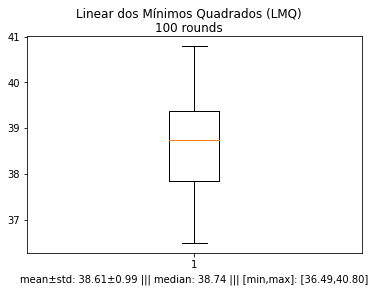

> Adaline (AD)
> Perceptron Logistico (PL)
> Multi-Layer Perceptron (MLP)


In [9]:
LMQ_classifier(data)
AD_classifier(data)
PL_classifier(data)
MLP_classifier(data)